# California housing regression

In this notebook we'll use the ``ITEA_regressor`` to search for a good expression, that will be encapsulated inside the  ``ITExpr_regressor`` class, and it will be used for the regression task of predicting California housing prices.

In [1]:
import numpy  as np
import pandas as pd

from sklearn import datasets

from sklearn.model_selection import train_test_split
from IPython.display         import display, Math, Latex

import matplotlib.pyplot as plt

from itea.regression import ITEA_regressor
from itea.inspection import *

import warnings; warnings.filterwarnings('ignore')

The California Housing data set contains 8 features.

In this notebook, we'll provide the transformation functions and their derivatives, instead of using the itea feature of extracting the derivatives using Jax.

## Creating and fitting an ``ITEA_regressor``

In [2]:
housing_data = datasets.fetch_california_housing() 
X, y         = housing_data['data'], housing_data['target']
labels       = housing_data['feature_names']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

tfuncs = {
    'log'      : np.log,
    'sqrt.abs' : lambda x: np.sqrt(np.abs(x)), 
    'id'       : lambda x: x,
    'sin'      : np.sin,
    'cos'      : np.cos,
    'exp'      : np.exp
}

tfuncs_dx = {
    'log'      : lambda x: 1/x,
    'sqrt.abs' : lambda x: x/( 2*(np.abs(x)**(3/2)) ),
    'id'       : lambda x: np.ones_like(x),
    'sin'      : np.cos,
    'cos'      : lambda x: -np.sin(x),
    'exp'      : np.exp,
}

reg = ITEA_regressor(
    gens         = 50,
    popsize      = 50,
    max_terms    = 5,
    expolim      = (0, 2),
    verbose      = 10,
    tfuncs       = tfuncs,
    tfuncs_dx    = tfuncs_dx,
    labels       = labels,
    random_state = 42,
    simplify_method = 'simplify_by_var'
).fit(X_train, y_train)

gen 	 min_fitness 	 mean_fitness 	 max_fitness 	 remaining (s)
0 	 0.9379050391920672 	 1.1237760220234088 	 1.1537010152616711 	 0min21seg
10 	 0.8272846090261381 	 0.881735672398493 	 1.0369699871900457 	 0min41seg
20 	 0.8136939314899935 	 0.8272938408550969 	 1.0107234916933154 	 0min37seg
30 	 0.7662163369724707 	 0.7870666345437662 	 0.8239470965278956 	 0min28seg
40 	 0.7446027645943587 	 0.7688907157500813 	 0.8071489614021656 	 0min12seg


## Inspecting the results from ``ITEA_regressor`` and ``ITExpr_regressor``

We can see the convergence of the fitness, the number of terms, or tree complexity by using the ``ITEA_summarizer``, an inspector class focused on the ``ITEA``:

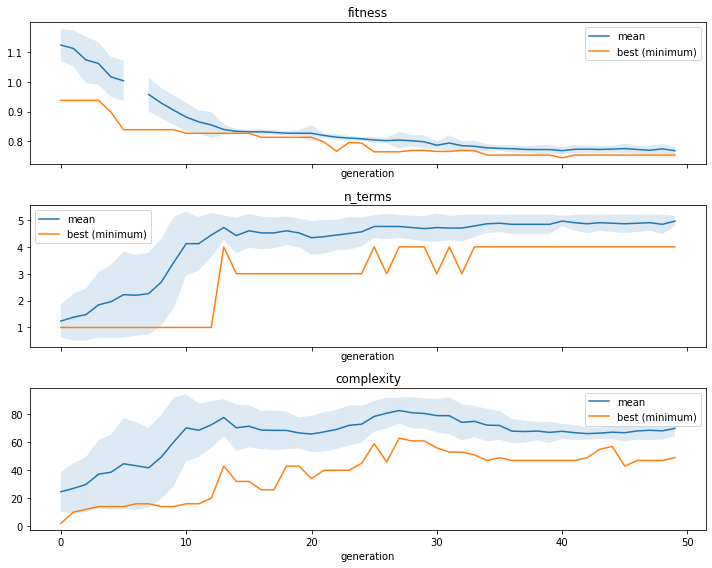

In [3]:
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

summarizer = ITEA_summarizer(itea=reg).fit(X_train, y_train)

summarizer.plot_convergence(
    data=['fitness', 'n_terms', 'complexity'],
    ax=axs,
    show=False
)

plt.tight_layout()
plt.show()

Now that we have fitted the ITEA, our ``reg`` contains the ``bestsol_`` attribute, which is a fitted instance of ``ITExpr_regressor`` ready to be used. Let us see the final expression and the execution time.

In [4]:
final_itexpr = reg.bestsol_

print('\nFinal expression:\n', final_itexpr.to_str(term_separator=' +\n'))
print(f'\nElapsed time: {reg.exectime_}')


Final expression:
 9.924*log(MedInc^2 * AveBedrms * Longitude^2) +
7.982*log(MedInc * HouseAge * AveRooms * AveOccup^2 * Longitude^2) +
-9.092*log(HouseAge * AveRooms * AveBedrms * AveOccup^2 * Latitude * Longitude^2) +
0.702*log(HouseAge^2 * AveBedrms * AveOccup^2 * Latitude^2 * Longitude^2) +
-25.846*log(MedInc) +
-62.377

Elapsed time: 60.5909264087677


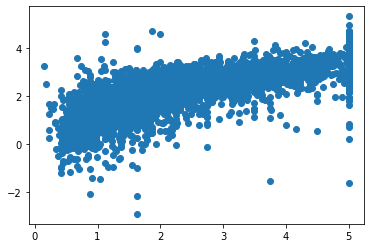

In [5]:
fig, axs = plt.subplots()

axs.scatter(y_test, final_itexpr.predict(X_test))
plt.show()

We can use the ``ITExpr_inspector`` to see information for each term.

In [6]:
display(pd.DataFrame(
    ITExpr_inspector(
        itexpr=final_itexpr, tfuncs=tfuncs
    ).fit(X_train, y_train).terms_analysis()
))

,coef,func,strengths,coef\nstderr.,mean pairwise\ndisentanglement,mean mutual\ninformation,prediction\nvar.
0,9.924,log,"[2, 0, 0, 1, 0, 0, 0, 2]",0.238,0.323,0.748,85.569
1,7.982,log,"[1, 1, 1, 0, 0, 2, 0, 2]",0.223,0.426,0.407,57.724
2,-9.092,log,"[0, 1, 1, 1, 0, 2, 1, 2]",0.222,0.361,0.439,55.374
3,0.702,log,"[0, 2, 0, 1, 0, 2, 2, 2]",0.013,0.312,0.379,0.778
4,-25.846,log,"[1, 0, 0, 0, 0, 0, 0, 0]",0.697,0.324,0.754,147.950
5,-62.377,intercept,---,1.501,0.000,0.000,0.000


## Explaining the ``IT_regressor`` expression using Partial Effects

We can obtain feature importances using the Partial Effects and the ``ITExpr_explainer``.

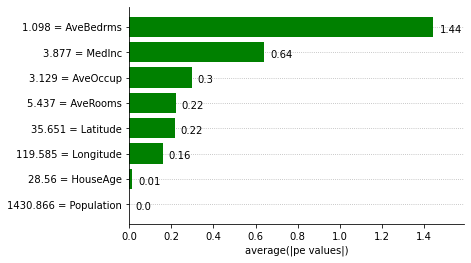

In [7]:
explainer = ITExpr_explainer(
    itexpr=final_itexpr, tfuncs=tfuncs, tfuncs_dx=tfuncs_dx).fit(X, y)

explainer.plot_feature_importances(
    X=X_train,
    importance_method='pe',
    grouping_threshold=0.0,
    barh_kw={'color':'green'}
)

The Partial Effects at the Means can help understand how the contribution of each variable changes according to its values when their covariables are fixed at the means.

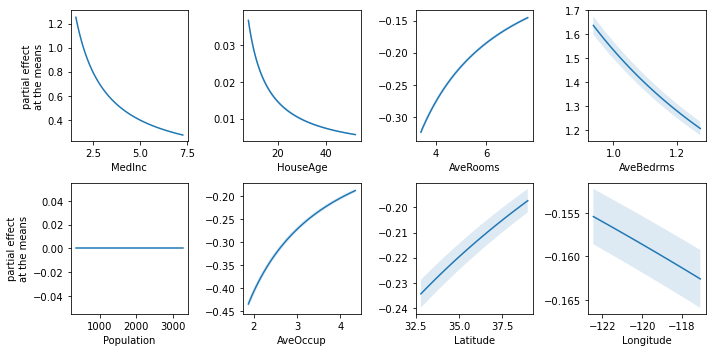

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

explainer.plot_partial_effects_at_means(
    X=X_test,
    features=range(8),
    ax=axs,
    num_points=100,
    share_y=False,
    show_err=True,
    show=False
)

plt.tight_layout()
plt.show()

Finally, we can also plot the mean relative importances of each feature by calculating the average Partial Effect for each interval when the output is discretized.

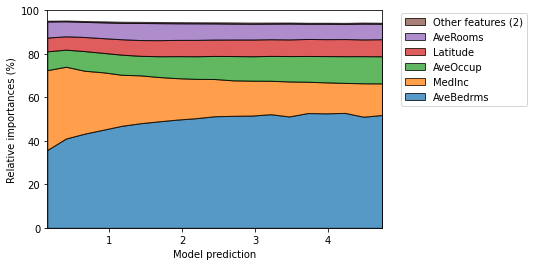

In [9]:
explainer.plot_normalized_partial_effects()